# Analisis de topicos en synopsis de Anime

## Inicializacion

In [1]:
import pandas as pd
import numpy as np
import os
import json
import re       # libreria de expresiones regulares
import string   # libreria de cadena de caracteres
import csv
import nltk
import matplotlib.pyplot as plt
from tqdm import tqdm
# !pip install contractions # instalamos
import contractions
# %matplotlib inline
pd.set_option('display.max_colwidth', 300)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import f1_score, accuracy_score
import os

# from google.colab import drive

In C:\Users\manoc\Anaconda3\envs\L_Datos\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\manoc\Anaconda3\envs\L_Datos\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\manoc\Anaconda3\envs\L_Datos\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\manoc\Anaconda3\envs\L_Datos\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\manoc\Anaconda3\envs\L_Datos

In [ ]:
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### *Funciones*

In [2]:
# Defino una funcion que recibe un texto y devuelve el mismo texto sin singnos,
def clean_text_round1(text):
    # pasa las mayusculas del texto a minusculas
    text = text.lower()                                              
    # reemplaza texto entre corchetes por espacio en blanco.. ¿ y \% no se..
    text = re.sub('\[.*?¿\]\%', ' ', text)                           
    # reemplaza signos de puntuacion por espacio en blanco.. %s -> \S+ es cualquier caracter que no sea un espacio en blanco
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) 
    # remueve palabras que contienen numeros.
    text = re.sub('\w*\d\w*', '', text)                              
    return text

# Hacemos una segunda vuelta de limpieza
def clean_text_round2(text):
    # Sacamos comillas, los puntos suspensivos, <<, >>
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    text = text.replace('—', ' ')
    return text

def rounds_genere(x):
    new_x = []
    for genere in x:
        text = clean_text_round1(genere)
        new_x.append(clean_text_round2(text))
    return new_x

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer() # funcion para lematizar
nltk.download('stopwords') # hay que descargar este modulo en particular
sw = nltk.corpus.stopwords.words('english') # lista de stopwords
# print(sw)

def remove_sw(text):
  words = text.split(' ') # separamos por espacios
  words_clean = []
  for w in words:
    if not w in sw: # si no es stopword, agregamos la version lematizada
      words_clean.append(lemmatizer.lemmatize(w))
  return ' '.join(words_clean)

def filter_words(text, filter_w):
  words = text.split(' ') # separamos por espacios
  words_clean = []
  for w in words:
    if not w in filter_w: # si no es stopword, agregamos la version lematizada
      words_clean.append(w)
  return ' '.join(words_clean)


import contractions
def synopsis_processing(synopsis):
    new_synopsis = contractions.fix(str(synopsis))
    new_synopsis = clean_text_round1(new_synopsis)
    new_synopsis = clean_text_round2(new_synopsis)
    new_synopsis = remove_sw(new_synopsis)
    
    return new_synopsis

def genders_processing(Genders):
    new_genders = Genders
    if type(Genders)==str:
        new_genders = Genders.split(', ')
    new_genders = rounds_genere(new_genders)
    return new_genders

#gets a list of all de generes in the dataset
def get_genders_list(df, key='Genders'):
    genders_list=[]
    for i in df.index:
        genders_list = genders_list + df[key][i]
    genders_list = list(dict.fromkeys(genders_list))
    return genders_list

# it creates a dataframe with the different generas and the number of times each appered
def get_Genders_count(df, key='Genders', genders_list=[], NoGender=False):
    if genders_list==[]:
        genders_list = get_genders_list(df, key)
    if NoGender==True:
        genders_list.append('')
    gender_counts = []
    df_Genders = pd.DataFrame({key: genders_list})
    for gender in genders_list:
        counter = 0
        none_counter = 0
        for i_Genders in df[key]:
            if i_Genders == []:
                none_counter += 1
            if gender in i_Genders:
                counter += 1
        gender_counts = np.append(gender_counts, counter)
    if NoGender==True:
        gender_counts[-1] = (none_counter)
    df_Genders['g_counts'] = gender_counts
    df_Genders.sort_values(by=['g_counts'], ascending=False, inplace=True)
    df_Genders.reset_index(drop=True, inplace=True)
    return df_Genders

def drop_rare_genders(Genders, df_counts, G_key='Genders', counts_key='g_counts', min_counts=20, empty_tag='Unknown'):
    rare_genders = df_counts[G_key][df_counts[counts_key] < min_counts].values
    # top_genders = df_counts[G_key][df_counts[counts_key] > min_counts]
    new_Genders = []
    for gender in Genders:
        if gender not in rare_genders:
            new_Genders.append(gender)
    if new_Genders==[]:
        new_Genders = [empty_tag]
    return new_Genders




[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\manoc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\manoc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preparado de Datos

### Carga de datos

In [3]:
# os.chdir('')
# os.listdir()
list_csv = [f_csv for f_csv in os.listdir() if f_csv.endswith('.csv')]
list_csv

['anime.csv',
 'anime_filtrado.csv',
 'anime_with_synopsis.csv',
 'dataframe_anime_1.csv',
 'Dataframe_anime_1_10000_V1.csv',
 'Dataframe_anime_1_5000_V1.csv']

Cargamos el dataset con las sinopsis

In [4]:
df_res = pd.read_csv('anime_with_synopsis.csv',
        index_col='MAL_ID', 
        # encoding="utf8", dialect='excel-tab',
        )
# spliter = lambda string: string.split(', ')
# df_res['Genders'] = df_res['Genders'].apply(spliter)
# df_res['Genders'][1]
# df.drop(columns='Japanese name', axis=1, inplace=True)
df_res.head(1)


,Name,Score,Genders,sypnopsis
MAL_ID,,,,
1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ra..."


### Procesado de Texto

#### Limpieza de los datos

Ahora vamos a descartar los mensajes que aparecen en los casos en que no hay una sinopsis cargada

In [ ]:
df_res.drop(df_res[df_res['sypnopsis']=='No synopsis information has been added to this title. Help improve our database by adding a synopsis here .'].index,
    inplace=True)
df_res.drop(df_res[df_res['sypnopsis']=='No synopsis has been added for this series yet. Click here to update this information.'].index,
    inplace=True)
df_res.drop(df_res[df_res['sypnopsis']=='No synopsis has been added for this series yet.'].index,
    inplace=True)

Procesamos los generos y textos con las funciones que se definieron antes

In [ ]:
df_res['Genders'] = df_res['Genders'].apply(genders_processing)
df_res['clean_summary'] = df_res['sypnopsis'].apply(synopsis_processing)

A continuacion vamos a sacar algunas palabras que hablan mas del formato del anime que de lo que transcurre en este.

In [ ]:
format_words = 'dvd, blu, included, ray, special, release, volume, bd, unaired, box, uta, nhk, minna, program, featured, video, song, animated, aired, usic, short, anime, series, film, story, animation, source, movie, based, episode, tv, aired, cap, special, season, recap, , video, song, album, directed, single, japanese, band, animated, featured, manga, bundled, volume, edition, limited, ovum, based, anime, original, ovas, game, mobile, card, online, anime, promotional, youtube, channel, official, franchise, released, version, character, feature, main, commercial, chan, show, featuring, japan, collaboration, anidb, new, first, second, two, part'
format_words = format_words.split(', ')
filter_w = lambda x: filter_words(x, format_words)
df_res['clean_summary'] = df_res['clean_summary'].apply(filter_w)
df_res.head(1)

,Name,Score,Genders,sypnopsis,clean_summary
MAL_ID,,,,,
1,Cowboy Bebop,8.78,"[action, adventure, comedy, drama, sci fi, space]","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ra...",year humanity colonized several planet moon solar system leaving uninhabitable surface planet earth behind inter solar system police attempt keep peace galaxy aided outlaw bounty hunter referred cowboy ragtag team aboard spaceship bebop individual mellow carefree spike spiegel balanced boisterou...


Ademas vamos a descartar los elementos que para los cuales los resumenes sean muy cortos ya que no transmiten demasiada informacion 

In [ ]:
splitter = lambda x: len(x.split(' '))
df_res.drop(df_res[df_res['clean_summary'].apply(splitter)<10].index,
    inplace=True)

#### Tokenizacion del texto

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer # Contador de frecuencia
from sklearn.feature_extraction.text import TfidfTransformer # Creador de tf-idf
from sklearn.decomposition import TruncatedSVD # Singular Value Decomposition

In [ ]:
# Lista de stopwords
stopwords = nltk.corpus.stopwords.words('english')
# Creamos el objeto contador de palabras, pidiéndole que remueve
# las stopwords, los términos que aparecen en un único documento (min_df)
# y los términos que aparecen en más del 70% de los documentos (max_df).
# Esto es para eliminar palabras raras (o errores de tipeo) y 
# términos que seguramente son stopwords no incluídos en la lista
count = CountVectorizer(min_df = 20, max_df = 0.70, stop_words = stopwords)

# Ajustamos con los datos. Acá especificamente creamos una matriz documentos-términos
x_count = count.fit_transform(df_res['clean_summary'])

# Dimensions de la matriz doc-tér
print(x_count.shape)

(10935, 3528)


Creamos el objeto tf-idf y le pedimos que devuelva los vectores documento con norma euclídea igual a 1 (norm = 'l2')

In [ ]:
tfidf = TfidfTransformer(norm = 'l2')

# Creamos la matriz tf-idf a partir de la matriz de frecuencias
x_tfidf = tfidf.fit_transform(x_count)
print(x_tfidf.shape)

(10935, 3528)


## Analisis de Topicos con NMF

In [ ]:
# Librería para hacer wordclouds
from wordcloud import WordCloud

# Algoritmos de descomposición de tópicos
from sklearn.decomposition import NMF 
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
# Elijamos la cantidad de tópicos
n_components = 10

# Construímos el objeto NMF con los tópicos indicados 
nmf = NMF(n_components = n_components)

# Aplicamos sobre nuestros datos
x_nmf = nmf.fit_transform(x_tfidf)

# Dimensión de la matriz transformada
print(x_nmf.shape)

(10935, 10)


Tomamos las palabras mas importantes de cada uno de los topicos

In [ ]:
# Objeto índice: término de nuestro vocabulario
vocabulary = {item: key for key, item in count.vocabulary_.items()}

# Para cada componente
for n in range(n_components):

  # Ordenamos una lista del largo de nuestro vocabulario según el peso en cada componente y nos quedamos con los primeros 10
  list_sorted = sorted(range(nmf.components_.shape[1]), reverse = True, key = lambda x: nmf.components_[n][x])[:10]

  # Printeamos los términos asociados a los valores más grande de cada una de las componentes
  print(', '.join([vocabulary[i] for i in list_sorted]))
  # print('\n')
  # 'One day', 'School', 'Comercial', 'Sci-Fi', 'Fantasy', 'Music', 'Romance', 'Sports', 'Family', 'New'

one, friend, day, time, find, get, however, make, go, way
school, high, student, club, class, academy, friend, year, member, teacher
cat, neko, dog, ann, black, named, adventure, human, comedy, stray
music, idol, also, project, group, theme, focus, studio, miku, fictional
world, power, human, demon, evil, monster, king, spirit, must, magic
girl, love, named, dream, magical, idol, boy, young, like, ann
team, baseball, player, soccer, tournament, play, match, member, high, basketball
child, book, picture, safety, ducational, teach, kid, fire, animal, tale
earth, planet, space, robot, alien, war, pilot, year, force, human
life, family, year, father, old, mother, boy, sister, ann, young


Creamos features determinando en que porcentajes pertenece cada elemento a los distintos topicos

In [ ]:
# Normalizador
from sklearn.preprocessing import Normalizer 

# Creamos un objeto para normalizar a que la suma dé 1
norm = Normalizer('l1')

# Sobreescribimos sobre la matriz de documentos-tópicos
x_nmf = norm.fit_transform(x_nmf)

# Guardemos en el dataframe esta información
for n in range(n_components):
  df_res['nmf_comp{}'.format(n)] = x_nmf[:,n]

# df_res.head(2)

Creamos una lista de todos los generos que hay en el Dataset.

In [ ]:
genders_list = get_genders_list(df_res)
len(genders_list)

42

Creamos un DataFrame con todos los generos y la cantidad de elementos hay en el dataset pertenecientes a cada uno de estos.

In [ ]:
df_Genders = get_Genders_count(df_res, genders_list=genders_list)
df_Genders.set_index('Genders',inplace=True)
df_Genders.head()

,g_counts
Genders,
comedy,4093.0
action,2975.0
fantasy,2352.0
adventure,2321.0
sci fi,2080.0


### WordClouds

Luego haremos WordClouds correspondientes a cada uno de los topicos obtenidos por NMF y mostraremos los generos que tienen mayor numero de elementos en cada topico (con componente mayor a 0.5 en ese topico)

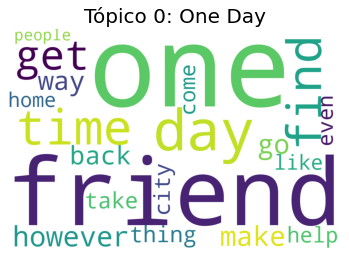

     Genders  g_counts
0     comedy     324.0
1  adventure     150.0
2    fantasy     147.0
3     action     139.0
4      drama     130.0


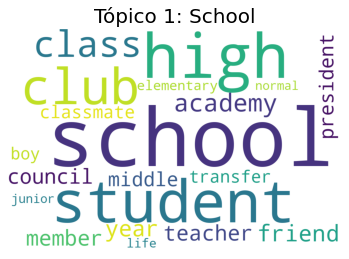

         Genders  g_counts
0         school     289.0
1         comedy     288.0
2        romance     133.0
3  slice of life     127.0
4          drama     102.0


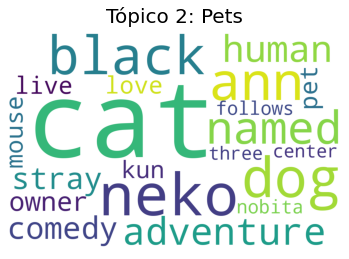

         Genders  g_counts
0         comedy      83.0
1           kids      44.0
2  slice of life      28.0
3        fantasy      26.0
4      adventure      23.0


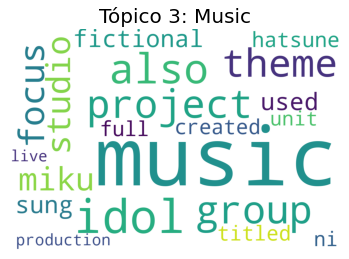

   Genders  g_counts
0    music     331.0
1     kids      53.0
2   comedy      46.0
3  fantasy      31.0
4   action      30.0


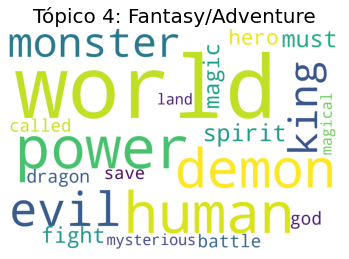

     Genders  g_counts
0    fantasy     422.0
1     action     406.0
2  adventure     378.0
3     comedy     292.0
4    shounen     178.0


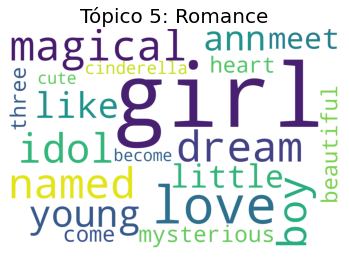

   Genders  g_counts
0   comedy     138.0
1  romance      74.0
2    drama      64.0
3  fantasy      62.0
4    music      51.0


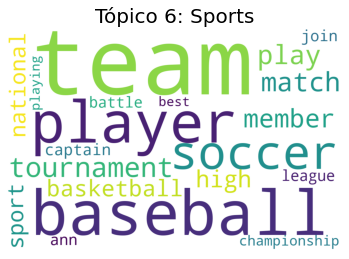

   Genders  g_counts
0   sports     175.0
1  shounen     122.0
2   comedy     111.0
3   action      88.0
4   school      60.0


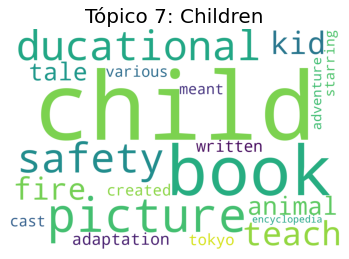

     Genders  g_counts
0       kids     236.0
1     comedy      79.0
2    fantasy      65.0
3      drama      62.0
4  adventure      48.0


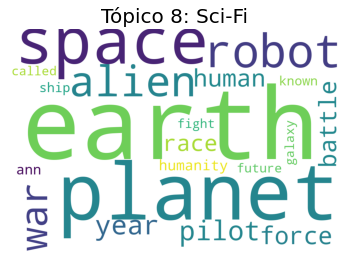

     Genders  g_counts
0     sci fi     445.0
1     action     307.0
2      mecha     280.0
3  adventure     206.0
4      space     193.0


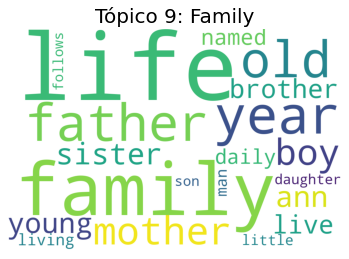

         Genders  g_counts
0         comedy     201.0
1          drama     171.0
2  slice of life     155.0
3           kids      99.0
4     historical      91.0


In [ ]:
# WordClouds with the most recurring genders for each topic
wc_atributos = {'height' : 800,
                'width' : 1200,
                'background_color' : 'white',
                'max_words' : 50
                } # Defino los parámetros que les voy a pasar a los wordclouds
 
# Creo la figura
 
Topic_labels = ['One Day', 'School', 'Pets', 'Music', 'Fantasy/Adventure', 'Romance', 'Sports', 'Children', 'Sci-Fi', 'Family']
# Recorro para todas las componentes
for n in range(n_components):
    fig, axs = plt.subplots(1, figsize = (6,1*5))
 
    # 10 términos más pesados
    list_sorted = sorted(range(len(vocabulary)), reverse = True, key = lambda x: nmf.components_[n][x])[:20]
 
    # Diccionario término: peso
    comp_dict = {vocabulary[i]: nmf.components_[n][i] for i in list_sorted}
 
    # Creo el wordlcoud
    wc = WordCloud(**wc_atributos # De esta forma, le estoy diciendo a la función que expanda el diccionario de atributos de forma tal de que entienda lo que quiero que haga
                    ).generate_from_frequencies(comp_dict)
 
    axs.set_title('Tópico {}: '.format(n)+Topic_labels[n], fontsize=20)
    axs.imshow(wc)
    axs.axis('off')
 
    plt.show()
    print(get_Genders_count(df_res[df_res['nmf_comp{}'.format(n)]>0.5], genders_list=genders_list).head())
 

Luego haremos algo similar pero en vez de ordenar los generos por cantidad de elementos normalizaremos este valor para evitar un sesgo hacia los generos mas poblados.

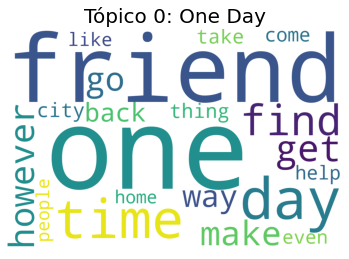

        Genders  g_counts  norm_count
0       mystery      92.0    0.150573
1        seinen      57.0    0.086364
2          kids     125.0    0.082454
3  supernatural      88.0    0.079855
4        comedy     324.0    0.079160


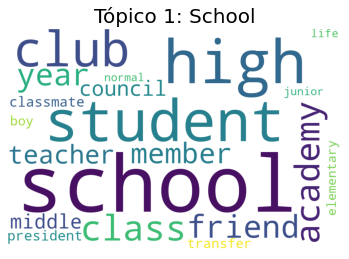

         Genders  g_counts  norm_count
0         school     289.0    0.240033
1  slice of life     127.0    0.095561
2          ecchi      51.0    0.089789
3        romance     133.0    0.087328
4         comedy     288.0    0.070364


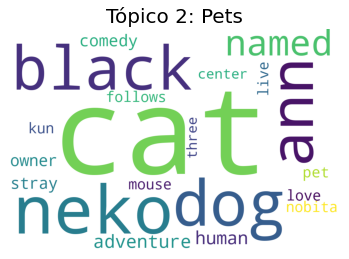

         Genders  g_counts  norm_count
0           kids      44.0    0.029024
1  slice of life      28.0    0.021068
2         comedy      83.0    0.020279
3        fantasy      26.0    0.011054
4      adventure      23.0    0.009910


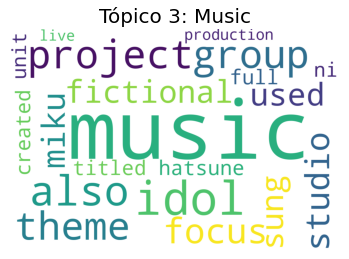

         Genders  g_counts  norm_count
0          music     331.0    0.309057
1       dementia      29.0    0.123932
2           kids      53.0    0.034960
3  slice of life      25.0    0.018811
4         sci fi      30.0    0.014423


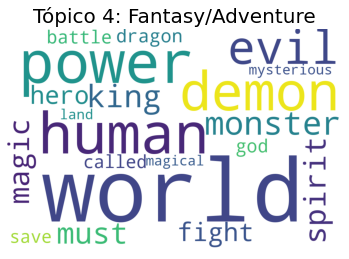

     Genders  g_counts  norm_count
0     demons      76.0    0.236025
1      magic     150.0    0.181159
2    fantasy     422.0    0.179422
3       game      53.0    0.178451
4  adventure     378.0    0.162861


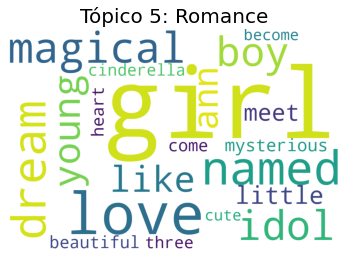

   Genders  g_counts  norm_count
0  romance      74.0    0.048588
1    music      51.0    0.047619
2   comedy     138.0    0.033716
3    drama      64.0    0.031174
4  fantasy      62.0    0.026361


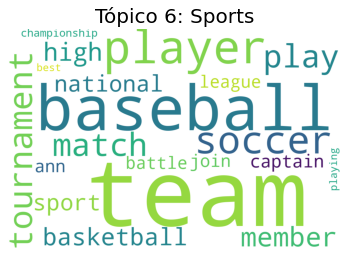

   Genders  g_counts  norm_count
0   sports     175.0    0.351406
1  shounen     122.0    0.076537
2   school      60.0    0.049834
3   action      88.0    0.029580
4    drama      58.0    0.028251


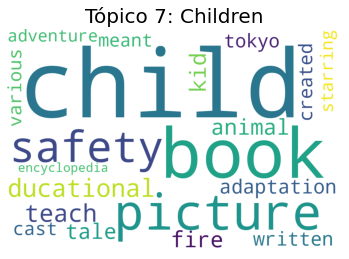

      Genders  g_counts  norm_count
0        kids     236.0    0.155673
1  historical      44.0    0.055980
2       music      47.0    0.043884
3       drama      62.0    0.030200
4     fantasy      65.0    0.027636


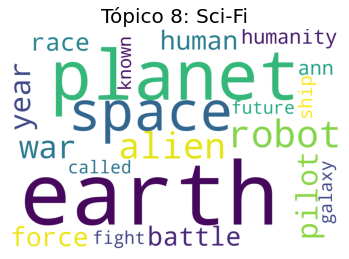

    Genders  g_counts  norm_count
0     space     193.0    0.511936
1     mecha     280.0    0.319270
2  military     122.0    0.277273
3    sci fi     445.0    0.213942
4    action     307.0    0.103193


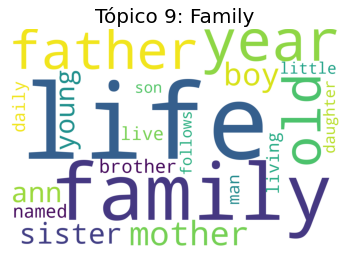

         Genders  g_counts  norm_count
0  slice of life     155.0    0.116629
1     historical      91.0    0.115776
2          drama     171.0    0.083293
3           kids      99.0    0.065303
4         comedy     201.0    0.049108


In [ ]:
#%% Normalized: WordClouds with the most recurring genders for each topic
wc_atributos = {'height' : 800,
                'width' : 1200,
                'background_color' : 'white',
                'max_words' : 20
                } # Defino los parámetros que les voy a pasar a los wordclouds

# Creo la figura
# Recorro para todas las componentes
for n in range(n_components):
    fig, axs = plt.subplots(1, figsize = (6,1*5))

    # 10 términos más pesados
    list_sorted = sorted(range(len(vocabulary)), reverse = True, key = lambda x: nmf.components_[n][x])[:20]

    # Diccionario término: peso
    comp_dict = {vocabulary[i]: nmf.components_[n][i] for i in list_sorted}

    # Creo el wordlcoud
    wc = WordCloud(**wc_atributos # De esta forma, le estoy diciendo a la función que expanda el diccionario de atributos de forma tal de que entienda lo que quiero que haga
                    ).generate_from_frequencies(comp_dict)

    axs.set_title('Tópico {}: '.format(n)+Topic_labels[n], fontsize=20)
    axs.imshow(wc)
    axs.axis('off')

    plt.show()
    df_temp = get_Genders_count(df_res[df_res['nmf_comp{}'.format(n)]>0.5], genders_list=genders_list)
    temp = []
    for i in df_temp.index:
        if df_Genders['g_counts'][df_temp['Genders'][i]] != 0:
            temp.append(df_temp['g_counts'][i]/df_Genders['g_counts'][df_temp['Genders'][i]])
        else:
            tmep.append(0)

    df_temp['norm_count'] = temp
    n_lim = 50
    while len(df_temp[df_temp['g_counts']>n_lim])<5:
        n_lim-=10
    
    df_temp = df_temp[df_temp['g_counts']>n_lim]

    # df_temp.drop(index=[df_temp['g_counts']<10], inplace=True)
    df_temp.sort_values(by='norm_count', ascending=False, inplace=True)
    df_temp.reset_index(drop=True, inplace=True)
    print(df_temp.head())



In [ ]:
df_temp = get_Genders_count(df_res[df_res['nmf_comp{}'.format(n)]>0.5], genders_list=genders_list)

# Merge con otro Dataset

In [ ]:
df_general = pd.read_csv('anime.csv',
        index_col='MAL_ID', 
        # encoding="utf8", dialect='excel-tab',
        )
df_general.head(1)

,Name,Score,Genders,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
MAL_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0


In [ ]:
df_general.drop(columns='Japanese name', axis=1, inplace=True)
df_general.head(1)

,Name,Score,Genders,English name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
MAL_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0


In [ ]:
df = df_res.merge(df_general.drop(columns=['Name', 'Genders', 'English name', 'Score']), 
    how='inner', on='MAL_ID')
df.head(1)

,Name,Score,Genders,sypnopsis,clean_summary,nmf_comp0,nmf_comp1,nmf_comp2,nmf_comp3,nmf_comp4,nmf_comp5,nmf_comp6,nmf_comp7,nmf_comp8,nmf_comp9,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
MAL_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Cowboy Bebop,8.78,"[action, adventure, comedy, drama, sci fi, space]","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ra...",year humanity colonized several planet moon solar system leaving uninhabitable surface planet earth behind inter solar system police attempt keep peace galaxy aided outlaw bounty hunter referred cowboy ragtag team aboard spaceship bebop individual mellow carefree spike spiegel balanced boisterou...,0.052297,0.051277,0.044159,0.14299,0.0,0.019348,0.178605,0.025962,0.439939,0.045422,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0


In [ ]:
df.sort_values('Popularity')

,Name,Score,Genders,sypnopsis,clean_summary,nmf_comp0,nmf_comp1,nmf_comp2,nmf_comp3,nmf_comp4,nmf_comp5,nmf_comp6,nmf_comp7,nmf_comp8,nmf_comp9,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
MAL_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1535,Death Note,8.63,"[mystery, police, psychological, supernatural, thriller, shounen]","shinigami, as a god of death, can kill any person—provided they see their victim's face and write their victim's name in a notebook called a Death Note. One day, Ryuk, bored by the shinigami lifestyle and interested in seeing how a human would use a Death Note, drops one into the human realm. Hi...",shinigami god death kill person provided see victim face write victim name notebook called death note one day ryuk bored shinigami lifestyle interested seeing human would use death note drop one human realm high school student prodigy light yagami stumble upon death note since deplores state wor...,0.191855,0.199804,0.000306,0.002319,0.546307,0.000000,0.000000,0.009031,0.023023,0.027356,TV,37,"Oct 4, 2006 to Jun 27, 2007",Fall 2006,"VAP, Konami, Ashi Production, Nippon Television Network, Shueisha",VIZ Media,Madhouse,Manga,23 min. per ep.,R - 17+ (violence & profanity),60.0,1,2589552,145201,122401,2146116,75054,80834,165147,557406.0,535252.0,415890.0,201522.0,68577.0,28048.0,10462.0,3692.0,2256.0,3586.0
16498,Shingeki no Kyojin,8.48,"[action, military, mystery, super power, drama, fantasy, shounen]","Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called titans, forcing humans to hide in fear behind enormous concentric walls. What makes these giants truly terrifying is that their taste for human flesh is not born out of hunger but what appears to be ...",century ago mankind slaughtered near extinction monstrous humanoid creature called titan forcing human hide fear behind enormous concentric wall make giant truly terrifying taste human flesh born hunger appears pleasure ensure survival remnant humanity began living within defensive barrier resul...,0.174136,0.020058,0.001072,0.000000,0.197973,0.000000,0.028296,0.003963,0.382127,0.192375,TV,25,"Apr 7, 2013 to Sep 29, 2013",Spring 2013,"Production I.G, Dentsu, Mainichi Broadcasting System, Pony Canyon, Kodansha, Mad Box, Pony Canyon Enterprise",Funimation,Wit Studio,Manga,24 min. per ep.,R - 17+ (violence & profanity),115.0,2,2531397,129844,140753,2182587,37345,44635,126077,470882.0,514879.0,459113.0,220228.0,70768.0,31141.0,11805.0,4637.0,2707.0,4939.0
5114,Fullmetal Alchemist: Brotherhood,9.19,"[action, military, adventure, comedy, drama, magic, fantasy, shounen]","""In order for something to be obtained, something of equal value must be lost."" Alchemy is bound by this Law of Equivalent Exchange—something the young brothers Edward and Alphonse Elric only realize after attempting human transmutation: the one forbidden act of alchemy. They pay a terrible pric...",order something obtained something equal value must lost alchemy bound law equivalent exchange something young brother edward alphonse elric realize attempting human transmutation one forbidden act alchemy pay terrible price transgression edward loses left leg alphonse physical body desperate sa...,0.365763,0.000000,0.000000,0.000000,0.296138,0.000000,0.014464,0.000000,0.176310,0.147325,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,"Aniplex, Square Enix, Mainichi Broadcasting System, Studio Moriken","Funimation, Aniplex of America",Bones,Manga,24 min. per ep.,R - 17+ (violence & profanity),1.0,3,2248456,183914,171871,1644938,75728,32456,323463,714811.0,401507.0,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0
11757,Sword Art Online,7.25,"[action, game, adventure, romance, fantasy]","In the year 2022, virtual reality has progressed by leaps and boun

In [ ]:
df.reset_index(inplace=True)
try:
  df.drop(columns='index', inplace=True)
  # df.drop(columns='level_0', inplace=True)
  pass
except:
  pass

df.head(2)

,MAL_ID,Name,Score,Genders,sypnopsis,clean_summary,nmf_comp0,nmf_comp1,nmf_comp2,nmf_comp3,nmf_comp4,nmf_comp5,nmf_comp6,nmf_comp7,nmf_comp8,nmf_comp9,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"[action, adventure, comedy, drama, sci fi, space]","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ra...",year humanity colonized several planet moon solar system leaving uninhabitable surface planet earth behind inter solar system police attempt keep peace galaxy aided outlaw bounty hunter referred cowboy ragtag team aboard spaceship bebop individual mellow carefree spike spiegel balanced boisterou...,0.052297,0.051277,0.044159,0.142990,0.000000,0.019348,0.178605,0.025962,0.439939,0.045422,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"[action, drama, mystery, sci fi, space]","other day, another bounty—such is the life of the often unlucky crew of the Bebop. However, this routine is interrupted when Faye, who is chasing a fairly worthless target on Mars, witnesses an oil tanker suddenly explode, causing mass hysteria. As casualties mount due to a strange disease sprea...",day another bounty life often unlucky crew bebop however routine interrupted faye chasing fairly worthless target mar witness oil tanker suddenly explode causing mass hysteria casualty mount due strange disease spreading smoke blast whopping three hundred million woolong price placed head suppos...,0.262386,0.000000,0.000000,0.011283,0.012824,0.000000,0.348372,0.015088,0.101002,0.249046,Movie,1,"Sep 1, 2001",Unknown,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


## Search

In [ ]:
# Search
word = 'Dragon'
# indices = []
# for i in df.index:
#     if word in df['Name'][i]:
#         indices.append(i)
# df.iloc[indices]

df[df['Name'].str.contains(word)].head() #Better way of doing the same thing

,MAL_ID,Name,Score,Genders,sypnopsis,clean_summary,nmf_comp0,nmf_comp1,nmf_comp2,nmf_comp3,nmf_comp4,nmf_comp5,nmf_comp6,nmf_comp7,nmf_comp8,nmf_comp9,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
192,223,Dragon Ball,8.0,"[adventure, comedy, fantasy, martial arts, shounen, super power]","Gokuu Son is a young boy who lives in the woods all alone—that is, until a girl named Bulma runs into him in her search for a set of magical objects called the ""Dragon Balls."" Since the artifacts are said to grant one wish to whoever collects all seven, Bulma hopes to gather them and wish for a ...",gokuu son young boy life wood alone girl named bulma run search set magical object called dragon ball since artifact said grant one wish whoever collect seven bulma hope gather wish perfect boyfriend gokuu happens possession dragon ball unfortunately bulma refuse way make deal tag along journey ...,0.261738,0.000000,0.000000,0.000000,0.401114,0.149279,0.055587,0.000000,0.000000,0.132281,TV,153,"Feb 26, 1986 to Apr 12, 1989",Winter 1986,Fuji TV,Funimation,Toei Animation,Manga,24 min. per ep.,PG-13 - Teens 13 or older,535.0,120,735546,13454,37544,600337,27310,23902,46453,88245.0,89656.0,134427.0,108758.0,39962.0,14806.0,3942.0,1392.0,834.0,1204.0
193,225,Dragon Ball GT,6.48,"[action, sci fi, adventure, comedy, super power, magic, fantasy, shounen]","Emperor Pilaf finally has his hands on the Black Star Dragon Balls after years of searching, which are said to be twice as powerful as Earth's normal ones. Pilaf is about to make his wish for world domination when he is interrupted by Gokuu Son. As a result, Pilaf flubs his wish and accidentally...",emperor pilaf finally hand black star dragon ball year searching said twice powerful earth normal one pilaf make wish world domination interrupted gokuu son result pilaf flub wish accidentally turn gokuu back child wish granted black star dragon ball scatter across galaxy however gokuu discovers...,0.098477,0.000000,0.048427,0.000000,0.199140,0.000000,0.026493,0.157983,0.427616,0.041865,TV,64,"Feb 7, 1996 to Nov 19, 1997",Winter 1996,Fuji TV,Funimation,Toei Animation,Manga,23 min. per ep.,PG-13 - Teens 13 or older,5974.0,262,472177,1878,9834,408494,7582,21120,25147,22680.0,23836.0,44045.0,74704.0,67689.0,42801.0,26843.0,11272.0,5903.0,4003.0
264,296,Dragon Drive,6.73,"[action, sci fi, adventure, comedy, fantasy, school, shounen]","If there's one word to describe Reiji Ozora, it would be ""quitter."" He can never find the motivation to finish anything, and loses interest at the drop of a hat. This all changes when his best friend Maiko introduces him to the new game ""Dragon Drive."" In this virtual reality game, each player i...",one word describe reiji ozora would quitter never find motivation finish anything loses interest drop hat change best friend maiko introduces dragon drive virtual reality player assigned dragon tailored match personality strength reiji hope big strong scary beast instead stuck chibi cute friendl...,0.334482,0.019694,0.000000,0.000000,0.429163,0.000000,0.216662,0.000000,0.000000,0.000000,TV,38,"Jul 4, 2002 to Mar 27, 2003",Summer 2002,"Bandai Visual, Nihon Ad Systems, TV Tokyo Music",Bandai Entertainment,Madhouse,Manga,25 min. per ep.,PG - Children,4761.0,3651,20176,52,1272,10560,1591,1858,4895,410.0,648.0,1444.0,2546.0,1902.0,1154.0,434.0,171.0,110.0,47.0
456,502,Dragon Ball Movie 1: Shen Long no Densetsu,6.83,"[action, adventure, comedy, fantasy, shounen, super power]","lling of Dragon Ball's origins, this is a different version of the meeting of Goku, Bulma, Oolong, and Yamucha. They are all looking for the dragon balls for different reasons when they cross paths with an evil king named Gourmeth, who is also looking for the dragon balls. (Source: ANN)",lling dragon ball origin differ

In [ ]:
f = lambda x: ' '.join(x)
df[df['Genders'].apply(f).str.contains('shounen')].head() 

,MAL_ID,Name,Score,Genders,sypnopsis,clean_summary,nmf_comp0,nmf_comp1,nmf_comp2,nmf_comp3,nmf_comp4,nmf_comp5,nmf_comp6,nmf_comp7,nmf_comp8,nmf_comp9,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
2,6,Trigun,8.24,"[action, sci fi, adventure, comedy, drama, shounen]","Vash the Stampede is the man with a $$60,000,000,000 bounty on his head. The reason: he's a merciless villain who lays waste to all those that oppose him and flattens entire cities for fun, garnering him the title ""The Humanoid Typhoon."" He leaves a trail of death and destruction wherever he goe...",vash stampede man bounty head reason merciless villain lay waste oppose flattens entire city fun garnering title humanoid typhoon leaf trail death destruction wherever go anyone count dead much make eye contact rumor say actuality vash huge softie claim never taken life avoids violence cost craz...,0.345757,0.000000,0.000000,0.005517,0.058253,0.000000,0.000000,0.000000,0.199276,0.391197,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,Victor Entertainment,"Funimation, Geneon Entertainment USA",Madhouse,Manga,24 min. per ep.,PG-13 - Teens 13 or older,266.0,201,558913,12944,29113,343492,25465,13925,146918,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
4,8,Bouken Ou Beet,6.98,"[adventure, fantasy, shounen, supernatural]","It is the dark century and the people are suffering under the rule of the devil, Vandel, who is able to manipulate monsters. The Vandel Busters are a group of people who hunt these devils, and among them, the Zenon Squad is known to be the strongest busters on the continent. A young boy, Beet, d...",dark century people suffering rule devil vandel able manipulate monster vandel buster group people hunt devil among zenon squad known strongest buster continent young boy beet dream joining zenon squad however one day result beet fault zenon squad defeated devil beltose five dying buster sacrifi...,0.140842,0.032279,0.000000,0.000000,0.334704,0.053502,0.036436,0.000000,0.142293,0.259944,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,"TV Tokyo, Dentsu",Unknown,Toei Animation,Manga,23 min. per ep.,PG - Children,3710.0,4369,13224,18,642,7314,766,1108,3394,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0
5,15,Eyeshield 21,7.95,"[action, sports, comedy, shounen]","Sena is like any other shy kid starting high school; he's just trying to survive. Constantly bullied, he's accustomed to running away. Surviving high school is about to become a lot more difficult after Hiruma, captain of the school's American football team, witnesses Sena's incredible agility a...",sena like shy kid starting high school trying survive constantly bullied accustomed running away surviving high school become lot difficult hiruma captain school american football team witness sena incredible agility speed escape bully hiruma scheme make sena running back school team devil bat h...,0.039902,0.372307,0.000000,0.000000,0.000000,0.000000,0.572786,0.015005,0.000000,0.000000,TV,145,"Apr 6, 2005 to Mar 19, 2008",Spring 2005,"TV Tokyo, Nihon Ad Systems, TV Tokyo Music, Shueisha","VIZ Media, Sentai Filmworks",Gallop,Manga,23 min. per ep.,PG-13 - Teens 13 or older,604.0,1003,148259,2066,13907,78349,14228,11573,30202,9226.0,14904.0,22811.0,16734.0,6206.0,2621.0,795.0,336.0,140.0,151.0
7,17,Hungry Heart: Wild Striker,7.59,"[slice of life, comedy, sports, shounen]","Kyosuke Kano has lived under the shadow of his successful brother Seisuke all his life who is a professional soccer player. Tired of being compared and downgraded at, he abandoned playing soccer until a boy from his new highschool discovered him and asked him to join their team. Kyosuke joins it...",kyosuke kano lived shadow successful brother seisuke life professional soccer player tired compared downgraded 

In [ ]:
df.set_index('MAL_ID', inplace=True)
df.head(2)

,Name,Score,Genders,sypnopsis,clean_summary,nmf_comp0,nmf_comp1,nmf_comp2,nmf_comp3,nmf_comp4,nmf_comp5,nmf_comp6,nmf_comp7,nmf_comp8,nmf_comp9,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
MAL_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Cowboy Bebop,8.78,"[action, adventure, comedy, drama, sci fi, space]","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ra...",year humanity colonized several planet moon solar system leaving uninhabitable surface planet earth behind inter solar system police attempt keep peace galaxy aided outlaw bounty hunter referred cowboy ragtag team aboard spaceship bebop individual mellow carefree spike spiegel balanced boisterou...,0.052297,0.051277,0.044159,0.142990,0.000000,0.019348,0.178605,0.025962,0.439939,0.045422,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
5,Cowboy Bebop: Tengoku no Tobira,8.39,"[action, drama, mystery, sci fi, space]","other day, another bounty—such is the life of the often unlucky crew of the Bebop. However, this routine is interrupted when Faye, who is chasing a fairly worthless target on Mars, witnesses an oil tanker suddenly explode, causing mass hysteria. As casualties mount due to a strange disease sprea...",day another bounty life often unlucky crew bebop however routine interrupted faye chasing fairly worthless target mar witness oil tanker suddenly explode causing mass hysteria casualty mount due strange disease spreading smoke blast whopping three hundred million woolong price placed head suppos...,0.262386,0.000000,0.000000,0.011283,0.012824,0.000000,0.348372,0.015088,0.101002,0.249046,Movie,1,"Sep 1, 2001",Unknown,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


## Evolucion en el tiempo

### Limpieza de las fechas

Creo una funcion para obtener la fecha de inicio del anime y lo agrego en una columna del dataframe ['date']

In [ ]:
from datetime import datetime

def get_dates(aired):
    if aired=='Unknown' or aired=='?':
        return np.nan
    if len(aired.split(' to ')[0].split(' '))>1:
        if len(aired.split(' to ')[0].split(' '))==2:
            return datetime.strptime(aired.split(' to ')[0], '%b, %Y')

        return datetime.strptime(aired.split(' to ')[0], '%b %d, %Y')
    
    return datetime.strptime(aired.split(' to ')[0], '%Y')
    
    
df['date'] = df['Aired'].apply(get_dates)
# dates =  datetime.strptime(df['Aired'][5].split(' to ')[0], '%b %d, %Y')
df[['Name', 'Score', 'Aired', 'Premiered', 'date']].head()

,Name,Score,Aired,Premiered,date
MAL_ID,,,,,
1,Cowboy Bebop,8.78,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,1998-04-03
5,Cowboy Bebop: Tengoku no Tobira,8.39,"Sep 1, 2001",Unknown,2001-09-01
6,Trigun,8.24,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,1998-04-01
7,Witch Hunter Robin,7.27,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,2002-07-02
8,Bouken Ou Beet,6.98,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,2004-09-30


Agrego una columna con el tiempo que estuvo al aire el anime ['time_span']

In [ ]:
def get_timespan(aired):
    if aired=='Unknown':
        return np.nan
    
    if len(aired.split(' to '))==1:
        return (get_dates(aired)-get_dates(aired))#Default_Dt
    if aired.split(' to ')[1]=='?':
        return (datetime.today().date() -get_dates(aired).date())#Default_Dt

    return ((get_dates(aired.split(' to ')[1]) - get_dates(aired.split(' to ')[0])))	

def get_timespan_years(aired):
    return get_timespan(aired).days / 365.2425

df['time_span'] = df['Aired'].apply(get_timespan)
df[['Name', 'Score', 'Aired', 'Premiered', 'date', 'time_span', 'Type']].head()

,Name,Score,Aired,Premiered,date,time_span,Type
MAL_ID,,,,,,,
1,Cowboy Bebop,8.78,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,1998-04-03,386 days,TV
5,Cowboy Bebop: Tengoku no Tobira,8.39,"Sep 1, 2001",Unknown,2001-09-01,0 days,Movie
6,Trigun,8.24,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,1998-04-01,182 days,TV
7,Witch Hunter Robin,7.27,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,2002-07-02,175 days,TV
8,Bouken Ou Beet,6.98,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,2004-09-30,364 days,TV


Agrego una columna con la fecha media entre el inicio y fin del anime ['mid_date']

In [ ]:
df['mid_date'] = (df['date'] + df['time_span']/2)

f = lambda x: x.days
df['time_span'] = df['time_span'].apply(f)
df[['Name', 'Score', 'Aired', 'Premiered', 'date', 'time_span', 'mid_date', 'Type']].head()

,Name,Score,Aired,Premiered,date,time_span,mid_date,Type
MAL_ID,,,,,,,,
1,Cowboy Bebop,8.78,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,1998-04-03,386.0,1998-10-13 00:00:00,TV
5,Cowboy Bebop: Tengoku no Tobira,8.39,"Sep 1, 2001",Unknown,2001-09-01,0.0,2001-09-01 00:00:00,Movie
6,Trigun,8.24,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,1998-04-01,182.0,1998-07-01 00:00:00,TV
7,Witch Hunter Robin,7.27,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,2002-07-02,175.0,2002-09-27 12:00:00,TV
8,Bouken Ou Beet,6.98,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,2004-09-30,364.0,2005-03-31 00:00:00,TV


In [ ]:
df[['Name', 'Score', 'Aired', 'Premiered', 'date', 'time_span', 'Type', 'mid_date']][df['Name'].str.contains('Dragon')]

,Name,Score,Aired,Premiered,date,time_span,Type,mid_date
MAL_ID,,,,,,,,
223,Dragon Ball,8.0,"Feb 26, 1986 to Apr 12, 1989",Winter 1986,1986-02-26,1141.0,TV,1987-09-19 12:00:00
225,Dragon Ball GT,6.48,"Feb 7, 1996 to Nov 19, 1997",Winter 1996,1996-02-07,651.0,TV,1996-12-28 12:00:00
296,Dragon Drive,6.73,"Jul 4, 2002 to Mar 27, 2003",Summer 2002,2002-07-04,266.0,TV,2002-11-14 00:00:00
502,Dragon Ball Movie 1: Shen Long no Densetsu,6.83,"Dec 20, 1986",Unknown,1986-12-20,0.0,Movie,1986-12-20 00:00:00
813,Dragon Ball Z,8.16,"Apr 26, 1989 to Jan 31, 1996",Spring 1989,1989-04-26,2471.0,TV,1992-09-12 12:00:00
...,...,...,...,...,...,...,...,...
39274,Dragon Quest: Your Story,6.85,"Aug 2, 2019",Unknown,2019-08-02,0.0,Movie,2019-08-02 00:00:00
39519,Dragon's Dogma,5.93,"Sep 17, 2020",Unknown,2020-09-17,0.0,ONA,2020-09-17 00:00:00
39531,Kuutei Dragons,7.05,"Jan 9, 2020",Unknown,2020-01-09,0.0,ONA,2020-01-09 00:00:00


### Topicos en el tiempo

Agrupacion por año

In [ ]:
f = lambda x: x.year
df['mid_year'] = df['mid_date'].apply(f)
topics = 'nmf_comp0 nmf_comp1 nmf_comp2 nmf_comp3 nmf_comp4 nmf_comp5 nmf_comp6 nmf_comp7 nmf_comp8 nmf_comp9'.split(' ')
df_year = df[['mid_year']+topics].groupby('mid_year').mean()
df_year.reset_index(inplace=True)
# Inspeccionemoslo
# df_year

In [ ]:
df['mid_year'].value_counts()

2017.0    589
2018.0    575
2016.0    538
2014.0    482
2019.0    469
         ... 
1944.0      1
1924.0      1
1955.0      1
1945.0      1
1927.0      1
Name: mid_year, Length: 95, dtype: int64

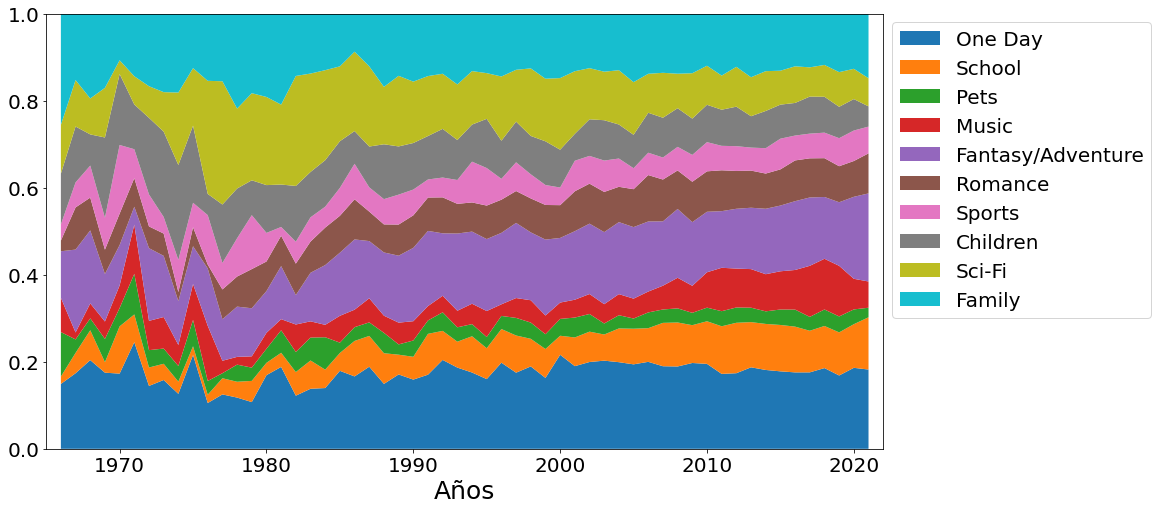

In [ ]:

# Topic_labels = ['Sci-Fi', 'School', 'Pets', 'Music', 'Fantasy', 'Romance', 'Sports', 'Family', 'History', 'One Day']

# El eje x es la año
lim_year = 1965
x = df_year['mid_year'][df_year['mid_year']>lim_year]

# El eje y son las distribuciones
y = df_year[df_year['mid_year']>lim_year][['nmf_comp{}'.format(i) for i in range(n_components)]].to_numpy()

plt.figure(figsize = (15,8))
plt.stackplot(x, y.T) # Stackplot: sirve para graficar distribuciones
plt.xlim([lim_year, 2022])
plt.ylim([0, 1.00])
plt.tick_params(labelsize=20)
# plt.yticks([])
plt.xlabel('Años', fontsize=25)
# plt.legend(['Tópico {}: {}'.format(i, Topic_labels[i]) for i in range(n_components)], loc = (1.05, 0.60))
plt.legend(['{}'.format(Topic_labels[i]) for i in range(n_components)], loc = (1.01, 0.30), fontsize=20)
plt.show()

# Prediccion de Popularidad

## Limpieza general de features

In [ ]:
df.head(1)

,Name,Score,Genders,sypnopsis,clean_summary,nmf_comp0,nmf_comp1,nmf_comp2,nmf_comp3,nmf_comp4,nmf_comp5,nmf_comp6,nmf_comp7,nmf_comp8,nmf_comp9,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,date,time_span,mid_date,mid_year,log10_Memb
MAL_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Cowboy Bebop,8.78,"[action, adventure, comedy, drama, sci fi, space]","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ra...",year humanity colonized several planet moon solar system leaving uninhabitable surface planet earth behind inter solar system police attempt keep peace galaxy aided outlaw bounty hunter referred cowboy ragtag team aboard spaceship bebop individual mellow carefree spike spiegel balanced boisterou...,0.052297,0.051277,0.044159,0.14299,0.0,0.019348,0.178605,0.025962,0.439939,0.045422,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1998-04-03,386.0,1998-10-13,1998.0,6.09759


In [ ]:
df[['Name', 'Score', 'Genders', 'Type', 'Producers', 'Licensors', 'Studios', 'Source', 'Duration', 'Rating']].head(2)

,Name,Score,Genders,Type,Producers,Licensors,Studios,Source,Duration,Rating
MAL_ID,,,,,,,,,,
1,Cowboy Bebop,8.78,"[action, adventure, comedy, drama, sci fi, space]",TV,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity)
5,Cowboy Bebop: Tengoku no Tobira,8.39,"[action, drama, mystery, sci fi, space]",Movie,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity)


###Duracion de los episodios

In [ ]:
def get_duration(t_string, NAN=True):
    mins=0
    list_string = t_string.split(' ')
    for i in range(1, len(list_string)):
        if 'min' in list_string[i]:
            mins += int(list_string[i-1])
        if 'hr' in list_string[i]:
            mins += 60*int(list_string[i-1])
        if 'sec' in list_string[i]:
            mins += int(list_string[i-1])/60
    if NAN==True:
        if t_string=='Unknown':
            mins=np.nan
    return mins

def get_score(Score_srting):
    if Score_srting=='Unknown':
        return np.nan
    return float(Score_srting)


In [ ]:
df['Duration'] = df['Duration'].apply(get_duration)
df['Score'] = df['Score'].apply(get_score)
df[['Name', 'Score', 'Type', 'Source', 'Duration']]

,Name,Score,Type,Source,Duration
MAL_ID,,,,,
1,Cowboy Bebop,8.78,TV,Original,24.0
5,Cowboy Bebop: Tengoku no Tobira,8.39,Movie,Original,115.0
6,Trigun,8.24,TV,Manga,24.0
7,Witch Hunter Robin,7.27,TV,Original,25.0
8,Bouken Ou Beet,6.98,TV,Manga,23.0
...,...,...,...,...,...
48466,Kyoukai Senki,NaN,TV,Original,NaN
48470,D_Cide Traumerei,NaN,TV,Original,NaN
48471,Tsuki to Laika to Nosferatu,NaN,TV,Light novel,NaN


In [ ]:
df.dropna(inplace=True)

df[['Name', 'Score', 'Type', 'Source', 'Duration']]

,Name,Score,Type,Source,Duration
MAL_ID,,,,,
1,Cowboy Bebop,8.78,TV,Original,24.0
5,Cowboy Bebop: Tengoku no Tobira,8.39,Movie,Original,115.0
6,Trigun,8.24,TV,Manga,24.0
7,Witch Hunter Robin,7.27,TV,Original,25.0
8,Bouken Ou Beet,6.98,TV,Manga,23.0
...,...,...,...,...,...
45567,Gekidan Nanatsu no Taizai,5.41,ONA,Original,2.0
45753,Tensei shitara Slime Datta Ken: Kanwa - Hinata Sakaguchi,6.54,Special,Light novel,23.0
46118,Wave!!: Surfing Yappe!! (TV),6.05,TV,Other,23.0


In [ ]:
Topics_keys = 'nmf_comp0 nmf_comp1 nmf_comp2 nmf_comp3 nmf_comp4 nmf_comp5 nmf_comp6 nmf_comp7 nmf_comp8 nmf_comp9'.split(' ')
X_param = df[['Score', 'Duration'] + Topics_keys].values

### Episodes


In [ ]:
def get_episode_count(episode_str):
    if episode_str=='Unknown':
        return 1
    return int(episode_str)


df['Episodes'] = df['Episodes'].apply(get_episode_count)
# df[np.logical_and(df['Episodes']=='Unknown', df['Type']=='TV')]
# df = df.drop(df[np.logical_and(df['Type']=='TV', df['Episodes']==1)])#=df[np.logical_and(df['Type']=='TV', df['Episodes']==1)]['Episodes'].apply(lambda x: np.nan)

### Limpieza de Features Categoricos
Tiro las etiquetas poco utilizadas como para features como por ejemplo Genders, Producers, Studios, etc

#### Genders

In [ ]:
# f = lambda x: x.split(', ')
# df['Genders'] = df['Genders'].apply(f)

In [ ]:
# Genders = get_genders_list(df, key='Genders')

In [ ]:
df_P = get_Genders_count(df, key='Genders', genders_list=[], NoGender=False)
df_P

,Genders,g_counts
0,comedy,3348.0
1,action,2692.0
2,adventure,1964.0
3,fantasy,1912.0
4,sci fi,1843.0
5,drama,1738.0
6,shounen,1485.0
7,romance,1420.0
8,school,1085.0
9,slice of life,1041.0


In [ ]:
dropper = lambda Genders: drop_rare_genders(Genders, df_P, G_key='Genders', counts_key='g_counts', min_counts=50)

df['Genders'] = df['Genders'].apply(dropper)

df[['Name', 'Score', 'Genders', 'Type', 'Genders']].head()

,Name,Score,Genders,Type,Genders
MAL_ID,,,,,
1,Cowboy Bebop,8.78,"[action, adventure, comedy, drama, sci fi, space]",TV,"[action, adventure, comedy, drama, sci fi, space]"
5,Cowboy Bebop: Tengoku no Tobira,8.39,"[action, drama, mystery, sci fi, space]",Movie,"[action, drama, mystery, sci fi, space]"
6,Trigun,8.24,"[action, sci fi, adventure, comedy, drama, shounen]",TV,"[action, sci fi, adventure, comedy, drama, shounen]"
7,Witch Hunter Robin,7.27,"[action, mystery, police, supernatural, drama, magic]",TV,"[action, mystery, police, supernatural, drama, magic]"
8,Bouken Ou Beet,6.98,"[adventure, fantasy, shounen, supernatural]",TV,"[adventure, fantasy, shounen, supernatural]"


In [ ]:
get_Genders_count(df, key='Genders', genders_list=[], NoGender=False)

,Genders,g_counts
0,comedy,3348.0
1,action,2692.0
2,adventure,1964.0
3,fantasy,1912.0
4,sci fi,1843.0
5,drama,1738.0
6,shounen,1485.0
7,romance,1420.0
8,school,1085.0
9,slice of life,1041.0


In [ ]:
multilabel_binarizer = MultiLabelBinarizer() #crea una matriz con ceros y unos. Si el genero está 1, sino 0
multilabel_binarizer.fit(df['Genders']) 
# animes['index1'] = animes.index
X_Genders = multilabel_binarizer.transform(df['Genders'])
print(X_Genders[0])
print(X_Genders.shape)

[0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 0 0 0 0]
(8293, 41)


#### Producers

In [ ]:
f = lambda x: x.split(', ')
df['Producers'] = df['Producers'].apply(f)

In [ ]:
Producers = get_genders_list(df, key='Producers')

In [ ]:
df_P = get_Genders_count(df, key='Producers', genders_list=[], NoGender=False)
df_P.head()

,Producers,g_counts
0,Unknown,2800.0
1,Aniplex,417.0
2,TV Tokyo,397.0
3,Bandai Visual,341.0
4,Lantis,340.0


In [ ]:
dropper = lambda Genders: drop_rare_genders(Genders, df_P, G_key='Producers', counts_key='g_counts', min_counts=50)

df['Producers'] = df['Producers'].apply(dropper)

df[['Name', 'Score', 'Genders', 'Type', 'Producers', 'Producers']].head()

,Name,Score,Genders,Type,Producers,Producers
MAL_ID,,,,,,
1,Cowboy Bebop,8.78,"[action, adventure, comedy, drama, sci fi, space]",TV,[Bandai Visual],[Bandai Visual]
5,Cowboy Bebop: Tengoku no Tobira,8.39,"[action, drama, mystery, sci fi, space]",Movie,[Bandai Visual],[Bandai Visual]
6,Trigun,8.24,"[action, sci fi, adventure, comedy, drama, shounen]",TV,[Victor Entertainment],[Victor Entertainment]
7,Witch Hunter Robin,7.27,"[action, mystery, police, supernatural, drama, magic]",TV,"[TV Tokyo, Bandai Visual, Dentsu, Victor Entertainment]","[TV Tokyo, Bandai Visual, Dentsu, Victor Entertainment]"
8,Bouken Ou Beet,6.98,"[adventure, fantasy, shounen, supernatural]",TV,"[TV Tokyo, Dentsu]","[TV Tokyo, Dentsu]"


In [ ]:
get_Genders_count(df, key='Producers', genders_list=[], NoGender=False)

,Producers,g_counts
0,Unknown,4261.0
1,Aniplex,417.0
2,TV Tokyo,397.0
3,Bandai Visual,341.0
4,Lantis,340.0
...,...,...
63,Dynamic Planning,52.0
64,Imagine,51.0
65,AIC,51.0
66,Sony Music Communications,50.0


In [ ]:
multilabel_binarizer = MultiLabelBinarizer() #crea una matriz con ceros y unos. Si el genero está 1, sino 0
multilabel_binarizer.fit(df['Producers']) 
# animes['index1'] = animes.index
X_Producers = multilabel_binarizer.transform(df['Producers'])
print(X_Producers[0])
print(X_Producers.shape)

[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(8293, 68)


#### Studios

In [ ]:
f = lambda x: x.split(', ')
df['Studios'] = df['Studios'].apply(f)

In [ ]:
# Studios = get_genders_list(df, key='Studios')

In [ ]:
df_P = get_Genders_count(df, key='Studios', genders_list=[], NoGender=False)
df_P

,Studios,g_counts
0,Unknown,1534.0
1,Toei Animation,525.0
2,Sunrise,377.0
3,Madhouse,310.0
4,J.C.Staff,281.0
...,...,...
535,Studio Core,1.0
536,Production GoodBook,1.0
537,Jumonji,1.0
538,Animation 21,1.0


In [ ]:
dropper = lambda Genders: drop_rare_genders(Genders, df_P, G_key='Studios', counts_key='g_counts', min_counts=50)

df['Studios'] = df['Studios'].apply(dropper)

df[['Name', 'Score', 'Genders', 'Type', 'Studios']].head()

,Name,Score,Genders,Type,Studios
MAL_ID,,,,,
1,Cowboy Bebop,8.78,"[action, adventure, comedy, drama, sci fi, space]",TV,[Sunrise]
5,Cowboy Bebop: Tengoku no Tobira,8.39,"[action, drama, mystery, sci fi, space]",Movie,[Bones]
6,Trigun,8.24,"[action, sci fi, adventure, comedy, drama, shounen]",TV,[Madhouse]
7,Witch Hunter Robin,7.27,"[action, mystery, police, supernatural, drama, magic]",TV,[Sunrise]
8,Bouken Ou Beet,6.98,"[adventure, fantasy, shounen, supernatural]",TV,[Toei Animation]


In [ ]:
get_Genders_count(df, key='Studios', genders_list=[], NoGender=False)

,Studios,g_counts
0,Unknown,4114.0
1,Toei Animation,525.0
2,Sunrise,377.0
3,Madhouse,310.0
4,J.C.Staff,281.0
5,Production I.G,236.0
6,Studio Deen,209.0
7,Studio Pierrot,197.0
8,TMS Entertainment,191.0
9,OLM,170.0


In [ ]:
multilabel_binarizer = MultiLabelBinarizer() #crea una matriz con ceros y unos. Si el genero está 1, sino 0
multilabel_binarizer.fit(df['Studios']) 
# animes['index1'] = animes.index
X_Studios = multilabel_binarizer.transform(df['Studios'])
print(X_Studios[0])
print(X_Studios.shape)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
(8293, 31)


#### Licensors

In [ ]:
f = lambda x: x.split(', ')
df['Licensors'] = df['Licensors'].apply(f)

In [ ]:
# Licensors = get_genders_list(df, key='Licensors')

In [ ]:
df_P = get_Genders_count(df, key='Licensors', genders_list=[], NoGender=False)
df_P

,Licensors,g_counts
0,Unknown,4932.0
1,Funimation,983.0
2,Sentai Filmworks,624.0
3,Discotek Media,341.0
4,ADV Films,284.0
...,...,...
63,DreamWorks,1.0
64,Brain's Base,1.0
65,OLM Digital,1.0
66,Crimson Star Media,1.0


In [ ]:
dropper = lambda Genders: drop_rare_genders(Genders, df_P, G_key='Licensors', counts_key='g_counts', min_counts=50)

df['Licensors'] = df['Licensors'].apply(dropper)

df[['Name', 'Score', 'Genders', 'Type', 'Licensors']].head()

,Name,Score,Genders,Type,Licensors
MAL_ID,,,,,
1,Cowboy Bebop,8.78,"[action, adventure, comedy, drama, sci fi, space]",TV,"[Funimation, Bandai Entertainment]"
5,Cowboy Bebop: Tengoku no Tobira,8.39,"[action, drama, mystery, sci fi, space]",Movie,[Unknown]
6,Trigun,8.24,"[action, sci fi, adventure, comedy, drama, shounen]",TV,"[Funimation, Geneon Entertainment USA]"
7,Witch Hunter Robin,7.27,"[action, mystery, police, supernatural, drama, magic]",TV,"[Funimation, Bandai Entertainment]"
8,Bouken Ou Beet,6.98,"[adventure, fantasy, shounen, supernatural]",TV,[Unknown]


In [ ]:
get_Genders_count(df, key='Licensors', genders_list=[], NoGender=False)

,Licensors,g_counts
0,Unknown,5284.0
1,Funimation,983.0
2,Sentai Filmworks,624.0
3,Discotek Media,341.0
4,ADV Films,284.0
5,Bandai Entertainment,183.0
6,Aniplex of America,180.0
7,Media Blasters,176.0
8,Geneon Entertainment USA,169.0
9,VIZ Media,156.0


In [ ]:
multilabel_binarizer = MultiLabelBinarizer() #crea una matriz con ceros y unos. Si el genero está 1, sino 0
multilabel_binarizer.fit(df['Licensors']) 
# animes['index1'] = animes.index
X_Licensors = multilabel_binarizer.transform(df['Licensors'])
print(X_Licensors[0])
print(X_Licensors.shape)

[0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0]
(8293, 16)


#### Rating

In [ ]:
f = lambda x: x.split(', ')
df_copy = df.copy()
df_copy['Rating'] = df_copy['Rating'].apply(f)

In [ ]:
# Rating = get_genders_list(df, key='Rating')

In [ ]:
get_Genders_count(df_copy, key='Rating', genders_list=[], NoGender=False)

,Rating,g_counts
0,PG-13 - Teens 13 or older,4178.0
1,G - All Ages,1730.0
2,R - 17+ (violence & profanity),921.0
3,R+ - Mild Nudity,722.0
4,PG - Children,663.0
5,Unknown,79.0


In [ ]:
multilabel_binarizer = MultiLabelBinarizer() #crea una matriz con ceros y unos. Si el genero está 1, sino 0
multilabel_binarizer.fit(df['Rating']) 
# animes['index1'] = animes.index
X_Rating = multilabel_binarizer.transform(df['Rating'])
print(X_Rating[0])
print(X_Rating.shape)

[1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 0
 1]
(8293, 38)


In [ ]:
df.shape

(8293, 49)

#### Source

In [ ]:
f = lambda x: x.split(', ')

df_copy = df.copy()
df_copy['Source'] = df_copy['Source'].apply(f)

In [ ]:
# Source = get_genders_list(df, key='Source')

In [ ]:
df_P = get_Genders_count(df_copy, key='Source', genders_list=[], NoGender=False)
df_P

,Source,g_counts
0,Manga,2534.0
1,Original,2092.0
2,Unknown,1177.0
3,Game,564.0
4,Light novel,541.0
5,Novel,328.0
6,Visual novel,292.0
7,Other,234.0
8,4-koma manga,168.0
9,Web manga,139.0


In [ ]:
dropper = lambda Genders: drop_rare_genders(Genders, df_P, G_key='Source', counts_key='g_counts', min_counts=0)[0]

df['Source'] = df_copy['Source'].apply(dropper)

def Join_Sources(Source):
    if 'manga' in Source:
        return 'Manga'
    if 'novel' in Source:
        return 'Novel'
    if 'book' in Source:
        return 'Book'
    if 'game' in Source:
        return 'Game'
    return Source
df['Source'] = df['Source'].apply(Join_Sources)

df[['Name', 'Score', 'Genders', 'Type', 'Source']].head()

,Name,Score,Genders,Type,Source
MAL_ID,,,,,
1,Cowboy Bebop,8.78,"[action, adventure, comedy, drama, sci fi, space]",TV,Original
5,Cowboy Bebop: Tengoku no Tobira,8.39,"[action, drama, mystery, sci fi, space]",Movie,Original
6,Trigun,8.24,"[action, sci fi, adventure, comedy, drama, shounen]",TV,Manga
7,Witch Hunter Robin,7.27,"[action, mystery, police, supernatural, drama, magic]",TV,Original
8,Bouken Ou Beet,6.98,"[adventure, fantasy, shounen, supernatural]",TV,Manga


In [ ]:
f = lambda x: x.split(', ')

df_copy2 = df.copy()
df_copy2['Source'] = df_copy2['Source'].apply(f)
get_Genders_count(df_copy2, key='Source', genders_list=[], NoGender=False)

,Source,g_counts
0,Manga,2849.0
1,Original,2092.0
2,Unknown,1177.0
3,Novel,1161.0
4,Game,606.0
5,Other,234.0
6,Book,92.0
7,Music,76.0
8,Radio,6.0


In [ ]:
multilabel_binarizer = MultiLabelBinarizer() #crea una matriz con ceros y unos. Si el genero está 1, sino 0
multilabel_binarizer.fit(df['Source']) 
# animes['index1'] = animes.index
X_Source = multilabel_binarizer.transform(df['Source'])
print(X_Source[0])
print(X_Source.shape)

[0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0]
(8293, 25)


## Modelo



### Arboles de decision y Random Forest

In [ ]:
# Modulos específicos para árboles de decisión
from sklearn.tree import DecisionTreeRegressor # Arboles de decisión para regresión
from sklearn.tree import plot_tree # Función para visualizar el árbol

from sklearn.ensemble import RandomForestRegressor # Random forests para decisión

# Módulos utiles para evaluar el modelo 
from sklearn.model_selection import train_test_split # Para separar en train y test
from sklearn.model_selection import cross_val_score # Para hacer cross-validation y evaluar el modelo

In [ ]:
df['log10_Memb'] = np.log10(df['Members'])

In [ ]:
# Lista de features que vamos a considerar 
features = [
            # 'Score', 
            # 'Genders', 
            'nmf_comp0',
            'nmf_comp1', 'nmf_comp2', 'nmf_comp3', 'nmf_comp4', 'nmf_comp5',
            'nmf_comp6', 'nmf_comp7', 'nmf_comp8', 'nmf_comp9', 'Episodes',
            # 'Type', 'Producers', 'Licensors', 'Studios', 'Source', 'Rating',
            'Duration', 'time_span', 'mid_year']
categorical_features = ['Type', 'Licensors', 'Studios', 'Source', 'Rating'] #'Producers' No puede estar ya que pueden haber multiples simultaneamente
# Variable a predecir
target = 'log10_Memb'

# Construcción de la matriz de features
X_num = df[features].to_numpy()

# Construcción del vector a predecir
y = df[target].to_numpy()

print('Dimensión de la matriz de features: {}'.format(X_num.shape))
print('Dimensión del vector a predecir: {}'.format(y.shape))
print('Vector a predecir: {}'.format(y))

Dimensión de la matriz de features: (8293, 14)
Dimensión del vector a predecir: (8293,)
Vector a predecir: [6.09759045 5.43639326 5.74734421 ... 4.29998644 3.22453306 2.92012333]


In [ ]:
from sklearn import preprocessing

categorical_features = ['Type', 
                        # 'Producers', 
                        # 'Licensors', 
                        # 'Studios', 
                        'Rating',
                        'Source',
                        ]
labelpross = []
n0 = 0
labelpross.append(preprocessing.LabelEncoder())
labelpross[-1].fit(df[categorical_features[n0]].values)
X_cat = labelpross[-1].transform(df[categorical_features[n0]].values).reshape(-1,1)

for cat in categorical_features[1:]:
    labelpross.append(preprocessing.LabelEncoder())
    labelpross[-1].fit(df[cat].values)
    X_aux = labelpross[-1].transform(df[cat].values).reshape(-1,1)
    X_cat = np.concatenate((X_cat, X_aux), axis=1)
# le = preprocessing.LabelEncoder()
# le.fit(["paris", "paris", "tokyo", "amsterdam"])
# le.transform(["tokyo", "tokyo", "paris"]) 
X_cat.shape

(8293, 3)

In [ ]:
# b = [[1],[2]]
# a = [[666],[999]]
# np.concatenate((b,a), axis=1)
# cat
X = np.concatenate((X_num, X_cat, X_Genders, X_Producers, X_Studios, X_Licensors), axis=1)


In [ ]:
# Solo por esta vez para a fijar la semilla de numeros aleatorios
# para que se separe siempre igual cada vez que corramos esta notebook 
random_seed = 123475

# Creacion de las matrices de entrenamiento y testeo. Aca fijamos la semilla para que siempre separe igual
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = random_seed)

print('Dimensión de la matriz de features para entrenamiento: {}'.format(X_train.shape))
print('Dimensión de la matriz de features para testeo: {}'.format(X_test.shape))

Dimensión de la matriz de features para entrenamiento: (7463, 173)
Dimensión de la matriz de features para testeo: (830, 173)


#### Arbol de decision

In [ ]:
# Construcción del árbol de decisión de profundidad 3 
dtr = DecisionTreeRegressor(max_depth = 10, random_state = random_seed)

# Observación: todos los algoritmos tienen una componente aleatoria: 
# solo por esta vez permitanme fijar la semilla de numeros aleatorios para que los resultados sean reproducibles.

In [ ]:
# Entrenamiento del modelo con el método fit
dtr.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=123475, splitter='best')

In [ ]:
# Score del modelo en los datos de entrenamiento (siempre esperamos que aquí sea alto)
score_in_train = dtr.score(X_train, y_train)

print('Score en el set de entrenamiento: {}'.format(score_in_train))

Score en el set de entrenamiento: 0.876564785250353


In [ ]:
# Score del modelo en los datos de testeo 
# (acá puede fluctuar pero en general es bajo respecto a los datos de entrenamiento)
score_in_test = dtr.score(X_test, y_test)

print('Score en el set de testeo: {}'.format(score_in_test))

Score en el set de testeo: 0.7397044978585983


In [ ]:
# Tomamos un valor de alpha entre 10^-10 y 1. Usamos un barrido logaritmico.
# for alpha in np.logspace(-10, 0, 11):
for alpha in np.linspace(0.0001, 0.001, 10):

    # Creamos el modelo para un dado valor de alpha
    dtr = DecisionTreeRegressor(ccp_alpha = alpha)

    # Calculamos los scores al hacer cross-validation con 5 folds 
    scores = cross_val_score(dtr, X_train, y_train, cv = 5)
    
    # Imprimimos el valor de alpha y el score medio
    print('Valor de alpha {} - Score medio = {}'.format(alpha, scores.mean()))

Valor de alpha 0.0001 - Score medio = 0.6901714204712853
Valor de alpha 0.00019999999999999998 - Score medio = 0.724907741283612
Valor de alpha 0.0003 - Score medio = 0.7372263536279855
Valor de alpha 0.00039999999999999996 - Score medio = 0.7392311529831087
Valor de alpha 0.0005 - Score medio = 0.7375195354142619
Valor de alpha 0.0006000000000000001 - Score medio = 0.734129082621221
Valor de alpha 0.0007 - Score medio = 0.7330815541518975
Valor de alpha 0.0007999999999999999 - Score medio = 0.7293479012831059
Valor de alpha 0.0009 - Score medio = 0.7282724132724472
Valor de alpha 0.001 - Score medio = 0.7243204782969708


In [ ]:
# Creación del modelo con regularización óptima 
dtr = DecisionTreeRegressor(ccp_alpha = 0.001)

# Entrenamiento
dtr.fit(X_train, y_train)

# Profundidad del árbol al entrenarlo regularizado
depth = dtr.get_depth() # Con este método vemos la profundidad
print('Profundidad del arbol = {}'.format(depth))

# Score en el set de testeo
score_in_test = dtr.score(X_test, y_test)
print('Score en el set de testeo: {}'.format(score_in_test))

Profundidad del arbol = 9
Score en el set de testeo: 0.738697522480112


#### Random Forest

In [ ]:
# Constuimos el modelo de Random Forest con 100 estimadores
# Por default, cada árbol individual es entrenado hasta máxima profundidad
rfr = RandomForestRegressor(n_estimators=100)

In [ ]:
# Entrenamiento del modelo 
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
# Score en el set de testeo

score_in_test = rfr.score(X_train, y_train)
print('Score en el set de testeo: {}'.format(score_in_test))

score_in_test = rfr.score(X_test, y_test)
print('Score en el set de testeo: {}'.format(score_in_test))

Score en el set de testeo: 0.9648017397784421
Score en el set de testeo: 0.732442817574561


La desventaja que tiene Random Forest por sobre los árboles de decisión es que son díficiles de interpretar. Ya no es tan cómo se predice un dado valor. Sin embargo, podemos inspeccionar un poco la importancia de cada feature con el siguiente atributo del modelo: 

In [ ]:
# Este atributo tiene una medida de la importancia de cada feature
feature_importance = rfr.feature_importances_ 
# 'Type', 'Rating', 'Source',, X_Genders, X_Producers, X_Studios, X_Licensors
print('Features:')
suma = 0
Sinop_sum = 0
sing_features = features + categorical_features
for i in range(len(sing_features)):
    suma += feature_importance[i]
    if 'nmf_comp' not in sing_features[i]:
        Sinop_sum += feature_importance[i]
    if 'nmf_comp' not in sing_features[i]:
        print('%s:  %.4f' %(sing_features[i], feature_importance[i]))
# Sinop_sum        
print('%s:  %.4f' %('Sinopsis', Sinop_sum))
i_prev = len(sing_features)
i_last = i_prev + X_Genders.shape[1]
suma+= np.sum(feature_importance[i_prev:i_last])
print('%s:  %.4f' %('Genders', np.sum(feature_importance[i_prev:i_last])))
i_prev = i_last
i_last += X_Producers.shape[1]
suma+= np.sum(feature_importance[i_prev:i_last])
print('%s:  %.4f' %('Producers', np.sum(feature_importance[i_prev:i_last])))
i_prev = i_last
i_last += X_Studios.shape[1]
suma+= np.sum(feature_importance[i_prev:i_last])
print('%s:  %.4f' %('Studios', np.sum(feature_importance[i_prev:i_last])))
i_prev = i_last
i_last += X_Licensors.shape[1]
suma+= np.sum(feature_importance[i_prev:i_last])
print('%s:  %.4f' %('Licensors', np.sum(feature_importance[i_prev:i_last])))


# print('%s:  %.4f' %('Sinopsis', np.sum(feature_importance[0:10]))) # si se calcula sin Score
print(suma)
# print('{}'.format(features + categorical_features))
# print('Importancia = ')
# print('{}'.format(feature_importance))

Features:
Score:  0.4824
Episodes:  0.0110
Duration:  0.0142
time_span:  0.0083
mid_year:  0.0978
Type:  0.0337
Rating:  0.0572
Source:  0.0159
Sinopsis:  0.7205
Genders:  0.0348
Producers:  0.0241
Studios:  0.0125
Licensors:  0.1145
1.0


Como se puede ver el Score aporta en un 48% la prediccion realizada. Dado que es cuetionable el poder acceder a una reseña al momento de querer ponen en practica el modelo, decidi correrlo sin este feature para evaluar cuanto esta variable afecta la calidad de las predicciones.
De esta manera se obtuvo una performance en el grupo de evaluacion de 0.732. 
Es decir que si bien la performance empeoro al quitar este feature el resultado sigue siendo aceptable

### SVM

In [ ]:
# X = np.concatenate((X_param, X_Genders, X_Producers, X_Studios, X_Licensors, X_Rating, X_Source), axis=1)
X = np.concatenate((X_num, X_Genders, X_Producers, X_Studios, X_Licensors, X_Rating, X_Source), axis=1)

X.shape

(8293, 234)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# clasificador: support vector classifier
from sklearn.svm import SVR

svr = SVR()#gamma=2, C=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4) # armo el split


scaler = MinMaxScaler() # escaleo por separado ambos sets
scaler.fit(X_train) 
X_train = scaler.transform(X_train)

scaler = MinMaxScaler() # escaleo por separado ambos sets
scaler.fit(X_test) 
X_test = scaler.transform(X_test)

svr.fit(X_train, y_train) # Ajustamos el modelo con los datos de entrenamiento

print(svr.score(X_train, y_train))
print(svr.score(X_test, y_test))
svr

0.8651069993677681
0.7819651104564346


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

#### Optimización de hiperparámetros


In [ ]:
def balanced_accuracy(cm): # funcion para calcular la "balanced accuracy"
    sensibilidad = cm[1,1]/(cm[1,1]+cm[0,1])
    especificidad = cm[0,0]/(cm[1,0]+cm[0,0])
    return [sensibilidad, especificidad, (sensibilidad + especificidad)/2]

def svregress(X,y,g,c, metric='Score'):  # X es la matriz de features, y los labels, n-1 la potencia máxima en la que aparecerán los features, C es la constante de regularización

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

    scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
    scaler.fit(X_train) # encuentro los parametros para el escaleo
    X_train = scaler.transform(X_train) # aplico la transformacion

    scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
    scaler.fit(X_test) # encuentro los parametros para el escaleo
    X_test = scaler.transform(X_test) # aplico la transformacion

    svr = SVR(gamma=g, C=c)
    svr.fit(X_train, y_train)
    if metric=='Score':
        train_score = svr.score(X_train, y_train)
        test_score = svr.score(X_test, y_test)

    return train_score, test_score    
    

In [ ]:
g_values = np.array([0.002, 0.02, 0.2, 2])#np.arange(0.2,5,0.2) # rango de constantes de regularizacion 
c_values = np.array([1, 10, 100, 1000, 10000])#np.arange(0.2,5,0.2) # rango de constantes de regularizacion

iterations = 10 # esto se puede poner en 100 para que no tarde mil años durante la clase

mean_score_train = np.zeros((len(g_values),len(c_values))) #  los arrays con los balanced accuracy para cada combinacion de hiperparametros, para train y test
mean_score_test = np.zeros((len(g_values),len(c_values)))

for xx,n in enumerate(g_values): # itero sobre n
    for yy,c in enumerate(c_values): # itero sobre c
      score_test_temp = [] # variables temporales para ir poniendo los resultados a lo largo de las iteraciones
      score_train_temp = []
      print([n,c]) # esto es para los ansiosos
      for it in np.arange(iterations): # itero
          score_train, score_test = svregress(X,y,n,c)  # calculo las balanced accuracy para esos hiperparametros
          score_test_temp.append(score_test) # agrego a las variables temporales
          score_train_temp.append(score_train)
      mean_score_train[xx,yy] = np.mean(score_train_temp) # calculo promedios
      mean_score_test[xx,yy] = np.mean(score_test_temp)


[0.002, 1]
[0.002, 10]
[0.002, 100]
[0.002, 1000]
[0.002, 10000]
[0.02, 1]
[0.02, 10]
[0.02, 100]
[0.02, 1000]
[0.02, 10000]
[0.2, 1]
[0.2, 10]
[0.2, 100]
[0.2, 1000]
[0.2, 10000]
[2.0, 1]
[2.0, 10]
[2.0, 100]
[2.0, 1000]
[2.0, 10000]


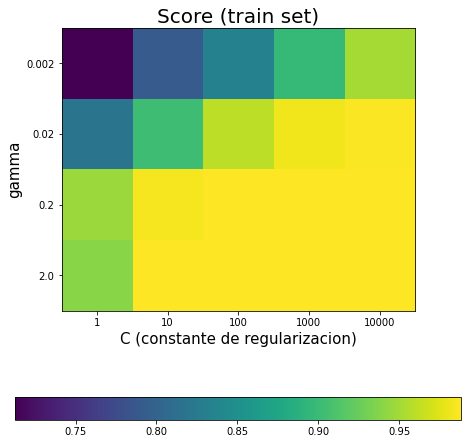

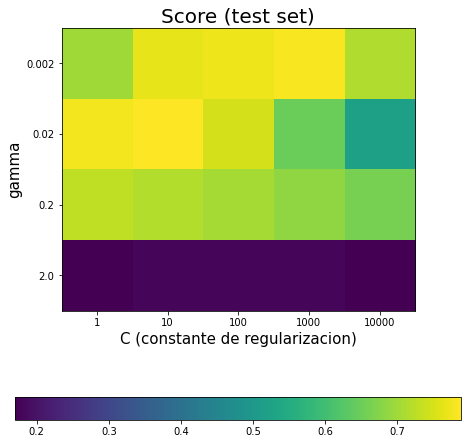

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))  # visualizacion train set
img = ax.imshow(mean_score_train) # graficamos la matriz
y_label_list = g_values # estos son los ticks de los ejes
x_label_list = c_values
ax.set_xticks(np.arange(len(c_values))) # creo los ticks de los ejes
ax.set_yticks(np.arange(len(g_values)))
ax.set_yticklabels(y_label_list) # pongo los ticks de los ejes
ax.set_xticklabels(x_label_list)
plt.xlabel('C (constante de regularizacion)', fontsize=15) # le pongo nombre a ejes y titulo 
plt.ylabel('gamma', fontsize=15)
plt.title('Score (train set)', fontsize=20)
fig.colorbar(img, orientation="horizontal", pad=0.2) # la barra de colores donde no me moleste

fig, ax = plt.subplots(1,1, figsize=(8,8)) # visualizacion test set, ver comentarios para el caso train, es idéntico
img = ax.imshow(mean_score_test)
y_label_list = g_values
x_label_list = c_values
ax.set_xticks(np.arange(len(c_values)))
ax.set_yticks(np.arange(len(g_values)))
ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)
plt.xlabel('C (constante de regularizacion)', fontsize=15)
plt.ylabel('gamma', fontsize=15)
plt.title('Score (test set)', fontsize=20)
fig.colorbar(img, orientation="horizontal", pad=0.2)


# Exploracion de Datos

In [ ]:
df_general['Score'] = df_general['Score'].apply(get_score)

for i in range(1,11):
    df_general['Score-{}'.format(i)] = df_general['Score-{}'.format(i)].apply(get_score)

df_general.dropna(inplace=True)

df_general.head(1)

,Name,Score,Genders,English name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
MAL_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0


In [ ]:
# for i in df_general.index:
# Score-10 	Score-9 	Score-8 	Score-7 	Score-6 	Score-5 	Score-4 	Score-3 	Score-2 	Score-1
score_sum = 0
suma = 0
for i in range(1, 11):
    score_sum += i*sum(df_general['Score-{}'.format(i)].values)
    suma += sum(df_general['Score-{}'.format(i)].values)
mean_score = score_sum/suma
mean_score

7.628336132702289

In [ ]:
print(df_general['Score'].mean(), ' +- ', df_general['Score'].std())


6.53756602839221  +-  0.874234127279781


In [ ]:
total_scores = df_general['Score-{}'.format(1)]
for i in range(2, 11):
    total_scores += df_general['Score-{}'.format(i)]
df_general['total_scores'] = total_scores
df_general[['Name', 'Score', 'total_scores']]

,Name,Score,total_scores
MAL_ID,,,
1,Cowboy Bebop,8.78,641705.0
5,Cowboy Bebop: Tengoku no Tobira,8.39,160349.0
6,Trigun,8.24,286146.0
7,Witch Hunter Robin,7.27,39094.0
8,Bouken Ou Beet,6.98,5923.0
...,...,...,...
46491,Santa Company: Manatsu no Merry Christmas,5.68,827.0
47398,Kimetsu Gakuen: Valentine-hen,6.59,5051.0
47402,Heikousen,7.52,419.0


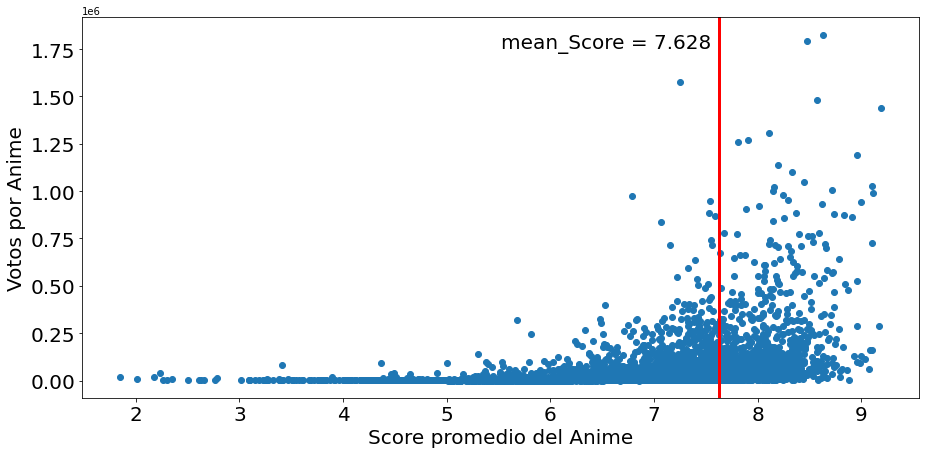

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7), 
                       sharey=True
                       )
# plt.plot(df['Score'], df['Completed'], 'o') #Ranked	Popularity
ax.plot((df_general['Score']), df_general['total_scores'], 'o') #Ranked	Popularity
# plt.xscale('log')
# plt.yscale('log')
ax.axvline(mean_score, color='r', linewidth=3)
ax.text(0.5,0.92, 'mean_Score = %.3f' %(mean_score),
        # style='bold'
        transform=ax.transAxes, fontsize=20
        )
ax.set_xlabel('Score promedio del Anime', fontsize=20)
ax.set_ylabel('Votos por Anime', fontsize=20)
ax.tick_params(labelsize=20)

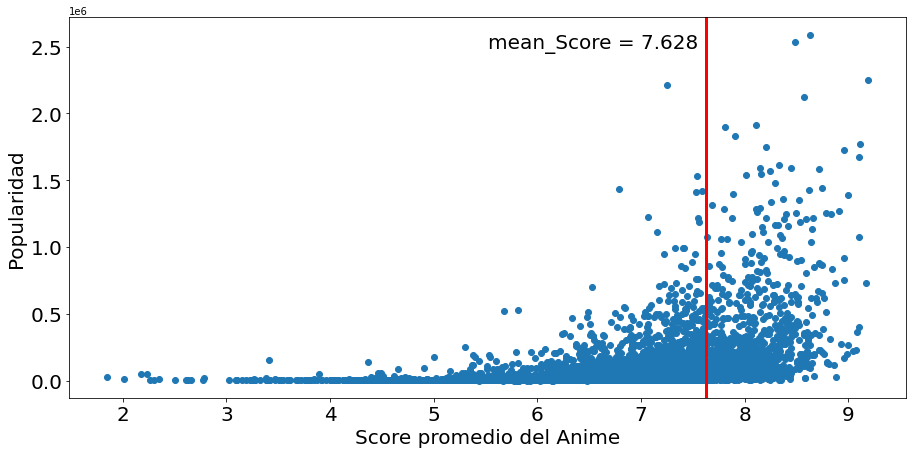

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7), 
                       sharey=True
                       )
# plt.plot(df['Score'], df['Completed'], 'o') #Ranked	Popularity
ax.plot((df_general['Score']), df_general['Members'], 'o') #Ranked	Popularity
# plt.xscale('log')
# plt.yscale('log')
ax.axvline(mean_score, color='r', linewidth=3)
ax.text(0.5,0.92, 'mean_Score = %.3f' %(mean_score),
        # style='bold'
        transform=ax.transAxes, fontsize=20
        )
ax.set_xlabel('Score promedio del Anime', fontsize=20)
ax.set_ylabel('Popularidad', fontsize=20)
ax.tick_params(labelsize=20)

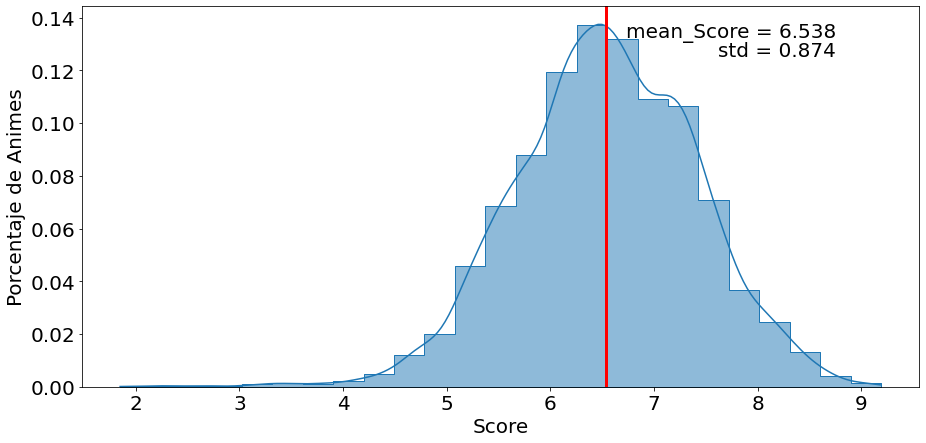

In [ ]:
import seaborn as sbn 

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7), 
                       sharey=True
                       )

# sbn.despine(fig)

sbn.histplot(data=df_general, x='Score', 
            #  hue='Grupo', 
             stat="probability", ax=ax, bins=25,
             common_norm=False,
             kde=True,
             element="step"
             )
ax.axvline(df_general['Score'].mean(), color='r', linewidth=3)
ax.text(0.65,0.92, 'mean_Score = %.3f' %(df_general['Score'].mean()),
        # style='bold'
        transform=ax.transAxes, fontsize=20
        )
ax.text(0.76,0.87, 'std = %.3f' %(df_general['Score'].std()),
        # style='bold'
        transform=ax.transAxes, fontsize=20
        )

ax.set_xlabel('Score', fontsize=20)
ax.set_ylabel('Porcentaje de Animes', fontsize=20)

plt.tick_params(labelsize=20)

In [ ]:
print(total_scores.mean(), ' +- ', total_scores.std())

25720.416474083857  +-  88794.05162620397


In [ ]:
# plt.plot(df['Score'], df['Completed'], 'o') #Ranked	Popularity
plt.plot((df['Members']), df['Popularity'], 'o') #Ranked	Popularity
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Members')
plt.ylabel('Popularity')

In [ ]:
# plt.plot(df['Score'], df['Completed'], 'o') #Ranked	Popularity
plt.plot((df['Favorites']), df['Popularity'], 'o') #Ranked	Popularity
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Faborites')
plt.ylabel('Popularity')


In [ ]:
# plt.plot(df['Score'], df['Completed'], 'o') #Ranked	Popularity
plt.plot((df['mid_year']), df['Popularity'], 'o') #Ranked	Popularity
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Year')
plt.ylabel('Popularity')